# <center>Classification problem: churn couriers</center>

### <center>Author: Adriana Patricia Vega</center>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics


For this excersice I am using Anaconda version 4.8.2 and Python Version 3.6.10 

In [2]:
df_lifetime = pd.read_csv('/Users/anunez/Documents/Curses/Test/Courier_lifetime_data.csv')
df_weekly = pd.read_csv('/Users/anunez/Documents/Curses/Test/Courier_weekly_data.csv')

## Problem statement

The manager of an important city needs to size the fleet of couriers in order to properly serve the orders we expect to get in the next few weeks. Since couriers are free to work or to stop working at any moment, they approach you and ask which couriers in the city fleet we can expect to work in the next 3 weeks (the churn window) and which couriers are not likely to come back, a classic churn problem. In order to act on the insights you provide, the city manager will need to have the predictions of your model available at least a week in advance.


### Plan

1. Data preparation

    - Create target variable

    - Explore and clean the data
    
    - Missing values and outliers
    

2. Exploratory data analysis
     
    - Analyse related features
    

3. Create a predictive algorithm

    - Prepare data for the preictive model
    
    - Predictive algorithms
    

4. Evaluating the model

## 1. Data preparation

### Create churn variable

Churn couriers are those who did not work in week 9,10, and/or 11. Therefore, in order to creat the churn variable I first created a flag variable to identify if a courier work in those weeks using the condition week>=9. Then, I group by curier and set the condition that the sum of the new variable (has_week_greater_9) is greater than 0, then we will have that the curier worked on week 9,10 and/or 11 (no_churn) and if it is 0 the curier did not work (churn).

In [3]:
df_weekly['has_week_greater_9'] = (df_weekly['week']>=9)*1
df_weekly['churned'] = df_weekly.groupby(['courier'])['has_week_greater_9'].transform(lambda x: np.where(np.sum(x)>0, 0, 1))

Check how many churned and not churned curiers do we have in the weekly dataframe

In [4]:
df_weekly.groupby('churned')['courier'].nunique() 

churned
0    387
1    372
Name: courier, dtype: int64

### Merge with lifetime data frame 

There are curriers that are part of the lifetime dataframe but not part of the weekly data. In that case, couriers that are not part of the weekly data are excluded from the analysis since they have already churned and did not worked in the previous 12 weeks. 

Therefore I left join the lifetime data with the weekly data.

In [5]:
df_lifetime.rename(columns={'feature_1':'category_one', 'feature_2':'category_two'}, inplace=True)
df_final = pd.merge(df_weekly, df_lifetime, how='left', on=['courier'])   


The next step is to remove the data for weeks 8, 9, 10 and 11

In [6]:
df_final = df_final[df_final.week < 8]

In the first exploration of the final data frame (df_final.info()), the only column with nan values is category_two. Since I do not know what does this variable represent I will replace the nan values with the mean.

In [7]:
df_final.fillna({'category_two':df_final.category_two.mean()}, inplace=True)

## 2. Exploratory data analysis

I will explore the relationship of our target variable (churn) with the other features.  

   - Difference between churners and non churners
   
   - Relationship between churn variable and the lifetime variables
   
   - Relationship between churn variable and the other features.
   
   - Correlation between continuos variables
   
   

### What is the proportion of churned couriers?

In [8]:
churn_perc = df_final[df_final.churned==1].courier.nunique() / df_final.courier.nunique()
print(f"Percentage of couriers that churned: {round(churn_perc*100, 1)}%")

Percentage of couriers that churned: 49.9%


### Number of weeks work by churned and non churned couriers 

Let's first have a look at how many weeks the churned and non churned couriers work during the weeks in analysis.

Text(0.5, 0, 'Churned')

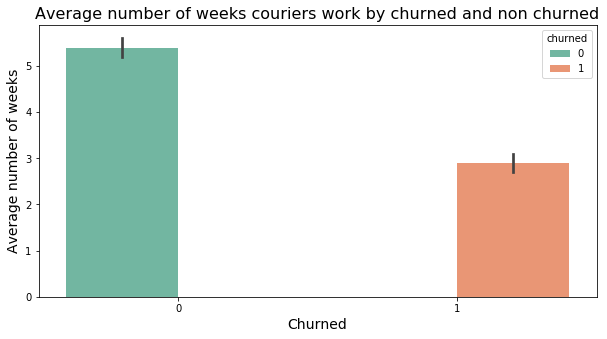

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='churned'
            , y='week'
            , hue='churned'
            , data=df_final.groupby(['churned', 'courier']).week.count().reset_index()
            , palette="Set2"
           )
ax.set_title('Average number of weeks couriers work by churned and non churned', fontsize=16)
ax.set_ylabel('Average number of weeks', fontsize=14)
ax.set_xlabel('Churned', fontsize=14)



The barplot shows churned couriers work less than non churned workers. 

### Churned and non churned couriers along weeks

Let's have a closer look of the distribution of churn and non churn curiers from week 0 to 7.

Text(0.5, 0, 'Weeks ')

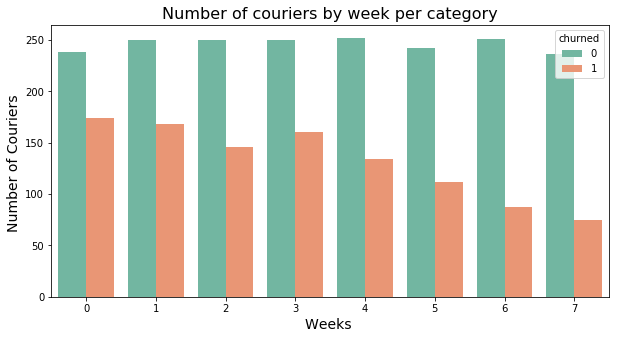

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='week'
            , y='courier'
            , hue='churned'
            , data=df_final.groupby(['churned', 'week']).courier.nunique().reset_index()
            , ax=ax
            , palette="Set2"
           )
ax.set_title("Number of couriers by week per category", fontsize=16)
ax.set_ylabel("Number of Couriers ", fontsize=14)
ax.set_xlabel("Weeks ", fontsize=14)


The graph shows that the number of non churned couriers along the training weeks (0-7 weeks) is very stable. However, the number of churned couriers shows important variations along the training period. We see a reduction of number of churned couriers, suggesting that some of the curiers who worked in the first weeks did not continue working in the next weeks.

### Ratio of number of weeks worked during the 8 weeks (0-7 week: training period)

I will create the ratio of number of weeks worked during the 8 weeks (0-7) per courier.

In [11]:
df_final['work_ratio'] = df_final.groupby(['churned', 'courier']).week.transform('count')/8

Text(0.5, 0, 'Churned')

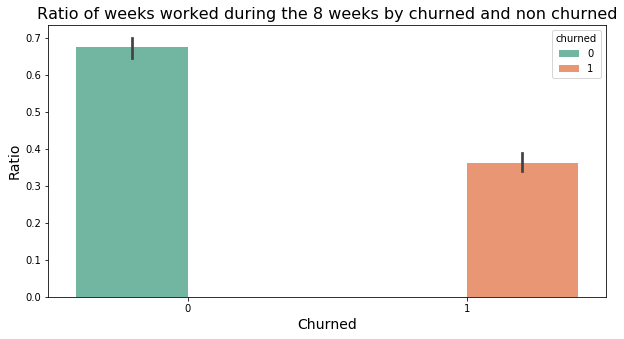

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='churned'
            , y='work_ratio'
            , hue='churned'
            , data=df_final.groupby(['churned','courier']).work_ratio.mean().reset_index()
            , palette="Set2"
           )
ax.set_title('Ratio of weeks worked during the 8 weeks by churned and non churned', fontsize=16)
ax.set_ylabel('Ratio', fontsize=14)
ax.set_xlabel('Churned', fontsize=14)



On average non churned couriers worked around 67% of the total number of weeks of the training period, while churned couriers on average worked around 36%.


### Couriers that worked three consecutive weeks in the training period.

I create a new variable in order to see which couriers worked and did not work 3 consecutive weeks (churn window) during the training period (0-7 week). This variable will be included in the model.

In [13]:
#Function to identify which couriers worked 3 weeks in a row
def three_weeks_in_row(weeks_list):
    
    weeks_list.sort()
    result=0
    for i in range(len(weeks_list)-2):
        if (weeks_list[i]==weeks_list[i+1]-1) & (weeks_list[i]==weeks_list[i+2]-2):
            result = 1
    return result

In [14]:
# Create a new column with the list of unique weeks worked for that courier 
df_final['unique_weeks'] = df_final.groupby(['courier'])['week'].transform('unique')
# Apply the function using the previous created column that has the list of weeks worked
df_final['worked_three_weeks_in_row'] = df_final.unique_weeks.apply(three_weeks_in_row)

Text(0.5, 0, 'Worked 3 consecutive weeks ')

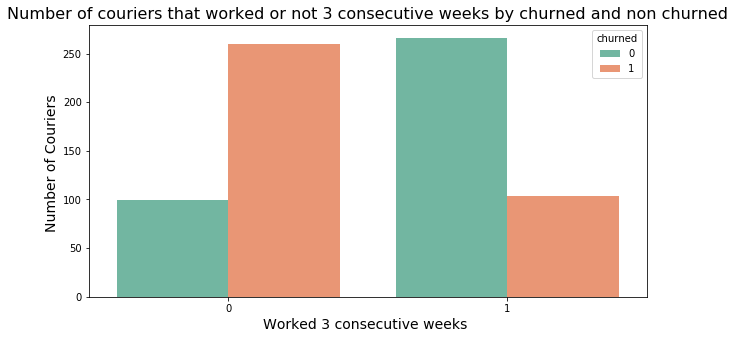

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='worked_three_weeks_in_row'
            , y='courier'
            , hue='churned'
            , data=df_final.groupby(['churned', 'worked_three_weeks_in_row']).courier.nunique().reset_index()
            , ax=ax
            , palette="Set2"
           )
ax.set_title("Number of couriers that worked or not 3 consecutive weeks by churned and non churned", fontsize=16)
ax.set_ylabel("Number of Couriers ", fontsize=14)
ax.set_xlabel("Worked 3 consecutive weeks ", fontsize=14)


We see that workers that did not worked 3 consecutive weeks are more likely to churn, while couriers that worked 3 consecutive weeks are less likely to churn.

### Exploring the relationship between churned variable and lifetime features.


#### Variable category_one

We have four unique categories a, b, c and d

Text(0.5, 0, 'Category_one ')

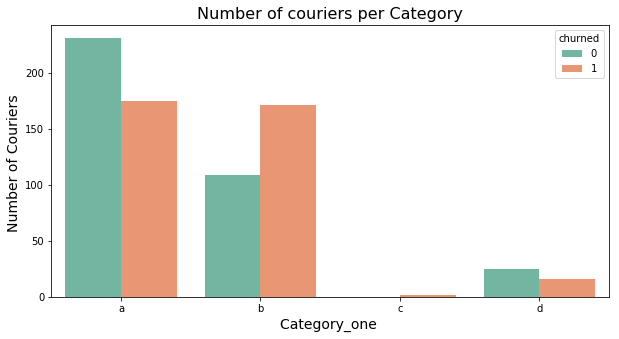

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='category_one'
            , y='courier'
            , hue='churned'
            , order = ['a', 'b', 'c', 'd']
            , data=df_final.groupby(['churned', 'category_one']).courier.nunique().reset_index()
            , ax=ax
            , palette="Set2"
           )
ax.set_title("Number of couriers per Category", fontsize=16)
ax.set_ylabel("Number of Couriers ", fontsize=14)
ax.set_xlabel("Category_one ", fontsize=14)



Since we don't have any information about what does this category represent, I am just going to briefly explain the graph. The majority of couriers (churn and non churn) are in category a and b. Specifically, category a has more non churn than churn couriers, while category b is the other way arround. On the other hand category c and d contains a small proportion of couriers.

#### Variable category_two 

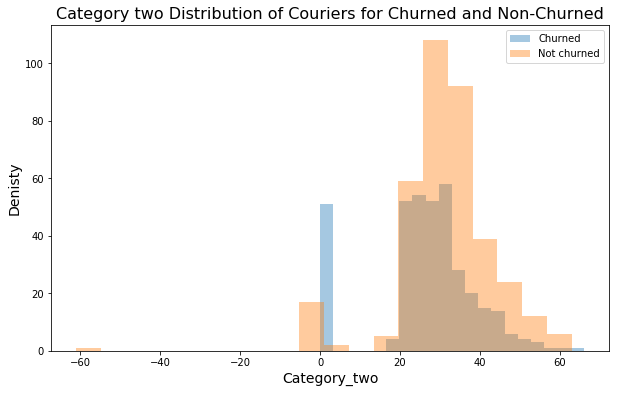

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
dict_churn = {1:'Churned', 0:'Not churned'}
for i in df_final.churned.unique():
    ax.hist(df_final[(df_final.churned==i)].groupby('courier')['category_two'].mean()
            , bins=20
            , label=dict_churn[i]
            , alpha = 0.4
           )
    ax.set_title("Category two Distribution of Couriers for Churned and Non-Churned", fontsize=16)
    ax.set_ylabel("Denisty", fontsize=14)
    ax.set_xlabel("Category_two", fontsize=14)
    plt.legend()

The distribution shows that the majority of churned and non churned couriers are concentrated between the values 20 and 40. As well, visually it seems that there is a difference in the means between the two type of couriers.

### Exploring the relationship between churn variable and the other features.

In this step I want to see how is the distribution of the remaining features of the data set (features 1-17) per churn and non churn couriers. Additionally, I show their correspondently boxplots to identify the presence of extreme values in each of the variables. Finally, I show some descriptive statistics (mean, median, standard deviation) of each feature separated by churn and non churn couriers.

This exploratory step can help us to get some first insights about how is the relationship between the 17 features and our target variable.

In [19]:
def distribution_feature(df, churn_col, courier_col, feature_col, ax):
    """
    Plot the distribution of a feature for churned and non-churned couriers. 
    
    :param df: pandas dataframe including the feature and the churned variable
    :param churn_col : name of the variable to compare (churned)
    :param courier_col: column name of the courier feature
    :param feature_col: column name of the variable to be plotted
    
    :return: distribution for each feature in feature_col separated by churn_col
    
    """
    
    dict_churn = {1:'Churned', 0:'Not churned'}
    for i in df[churn_col].unique():
        ax.hist(df[(df[churn_col]==i)].groupby([courier_col])[feature_col].mean()
            , bins=20
            , label=dict_churn[i]
            , alpha = 0.4
           )
        ax.set_title(f"Distribution {feature_col}", fontsize=16)
        ax.set_ylabel("Denisty", fontsize=14)
        ax.set_xlabel(f"{feature_col}", fontsize=14)
        ax.legend()

In [20]:
def boxplot_feature(df, churn_col, feature_col, axis):
    
    """
    Plot the boxplot of a feature for churned and non-churned couriers. 
    
    :param df: pandas dataframe including the feature and the churned variable
    :param churn_col : name of the variable to compare (churned)
    :param feature_col: column name of the variable to be plotted
    :param axis: figure axis 
    
    :return: boxplot for each feature in feature_col separated by churn_col
    
    """
    
    b = sns.boxplot(x=churn_col
                , y=feature_col
                , ax=axis
                , data=df
                , palette="Set2")
    b.set_title(f"Boxplot {feature_col}", fontsize=16)
    b.set_xlabel(f"{churn_col}",fontsize=14)
    b.set_ylabel(f"{feature_col}",fontsize=14)

In [21]:
def plot_grid(df, churn_col, courier_col, feature_col):
    
    """
    Shows 2 figures including the distribution and boxplot for each column specified in feature_col
    separated by the churn_col.
    Additionally, it prints the descriptive statistics (mean, median and standar deviation) for each feature
    by churned and non churned separately.
    
    :param df: pandas dataframe including the feature and the churned variable
    :param churn_col : name of the variable to compare (churned)
    :param courier_col: column name of the courier feature
    :param, feature_col: column name of the variable to be plotted.
    
    :return: distribution, boxplot and descriptive statistics for each feature in feature_col
    
    """
    
    fig, [ax,ax1] = plt.subplots(ncols=2,nrows=1,figsize=(19,5))
    
    boxplot_feature(df=df, churn_col=churn_col, feature_col=feature_col, axis=ax1)
    distribution_feature(df=df, churn_col=churn_col, courier_col=courier_col, feature_col=feature_col, ax=ax)
    
    plt.show()

    dict_churn = {1:'Churned', 0:'Not churned'}
    for i in df[churn_col].unique():
        print(dict_churn[i])
        mean = df[(df.churned==i)][feature_col].mean()
        median = df[(df.churned==i)][feature_col].median()
        std = df[(df.churned==i)][feature_col].std()
        print(f"Mean: {round(mean,3)}\nMedian: {round(median,3)}\nStd.: {round(std,3)}")
        print(20*"=")
    

In [22]:
plot_features = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5'
            ,'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10'
            ,'feature_11', 'feature_12', 'feature_13', 'feature_14'
            ,'feature_15','feature_16', 'feature_17',]

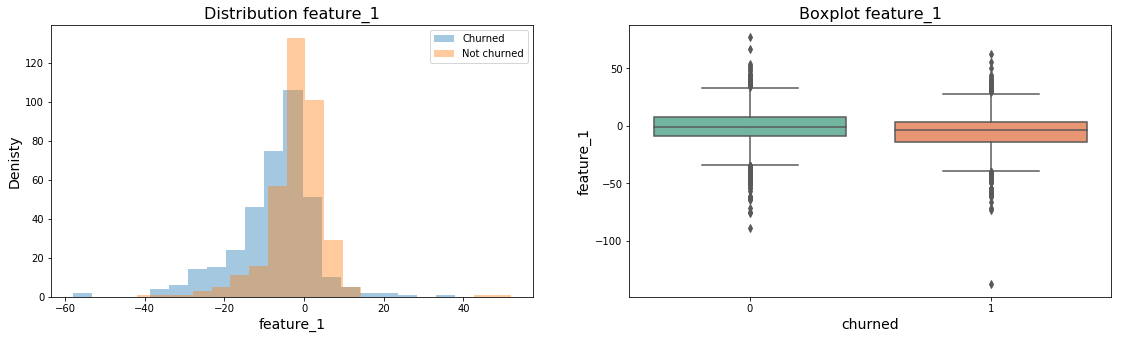

Churned
Mean: -6.056
Median: -4.0
Std.: 17.01
Not churned
Mean: -1.197
Median: -1.0
Std.: 15.766


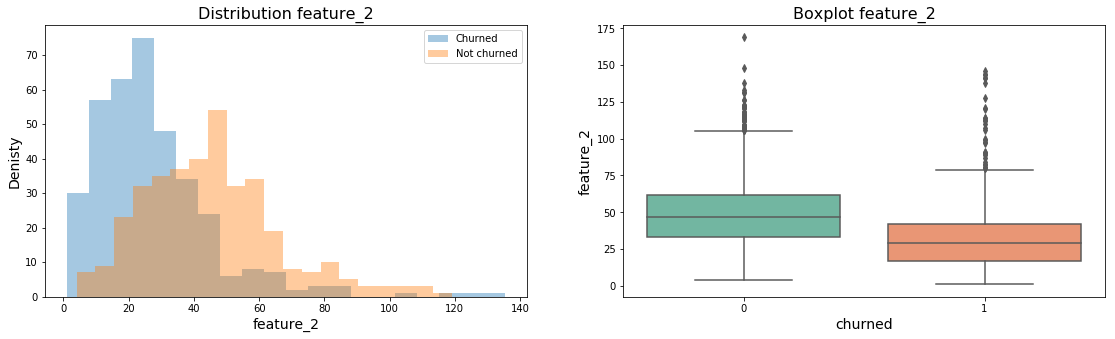

Churned
Mean: 32.947
Median: 29.0
Std.: 21.914
Not churned
Mean: 48.98
Median: 47.0
Std.: 22.826


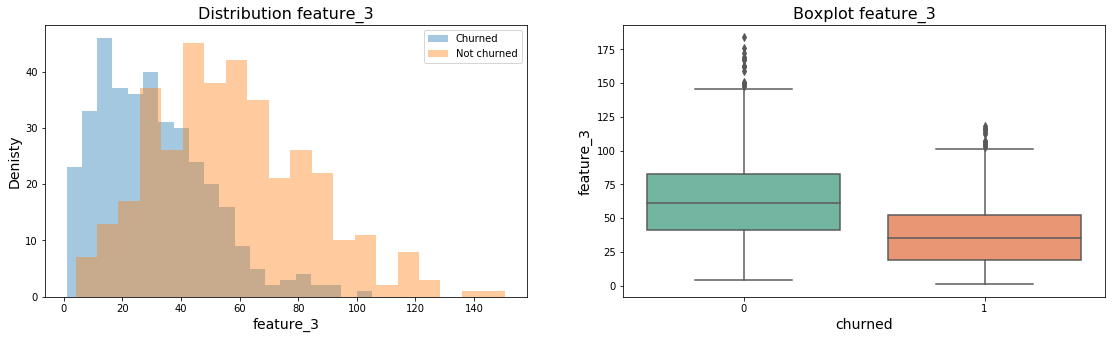

Churned
Mean: 37.958
Median: 35.0
Std.: 23.511
Not churned
Mean: 63.335
Median: 61.0
Std.: 30.28


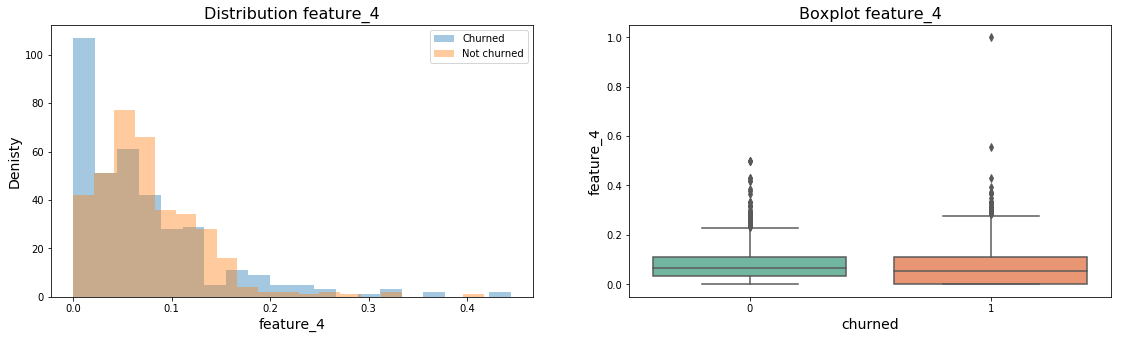

Churned
Mean: 0.073
Median: 0.053
Std.: 0.082
Not churned
Mean: 0.079
Median: 0.067
Std.: 0.066


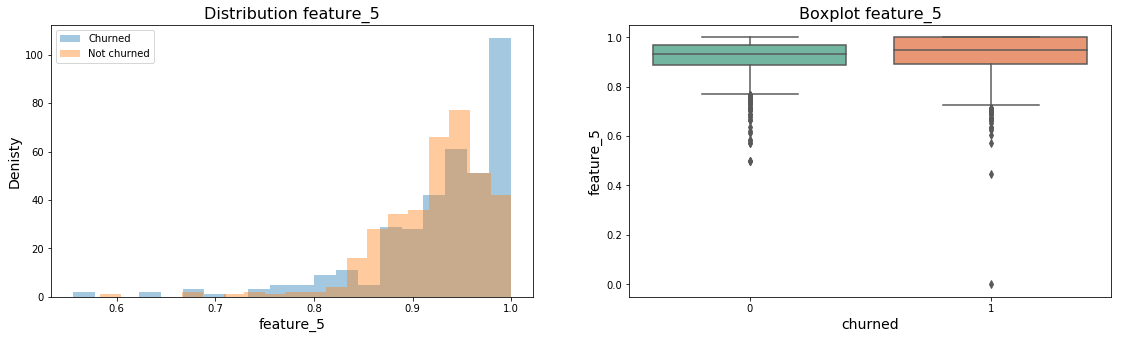

Churned
Mean: 0.927
Median: 0.947
Std.: 0.082
Not churned
Mean: 0.921
Median: 0.933
Std.: 0.066


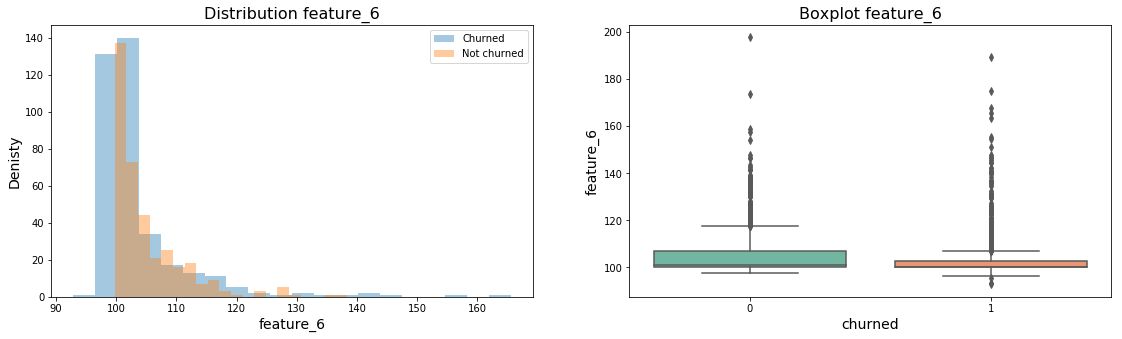

Churned
Mean: 104.067
Median: 100.0
Std.: 9.499
Not churned
Mean: 105.021
Median: 101.152
Std.: 8.4


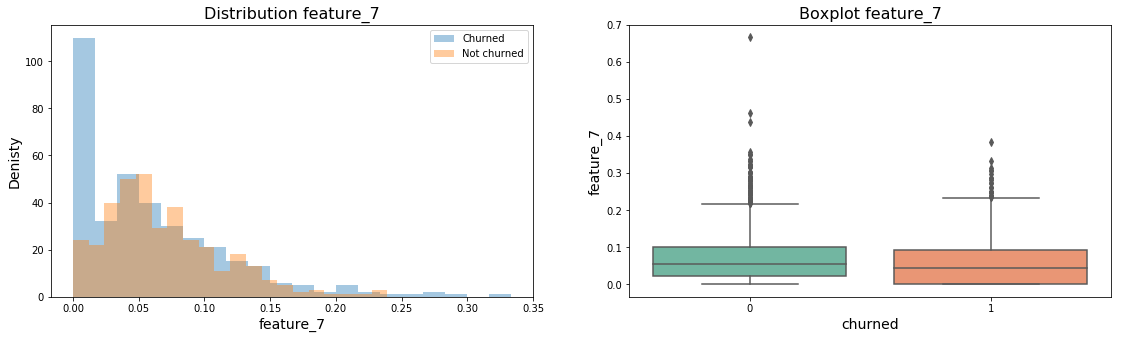

Churned
Mean: 0.06
Median: 0.043
Std.: 0.065
Not churned
Mean: 0.069
Median: 0.056
Std.: 0.065


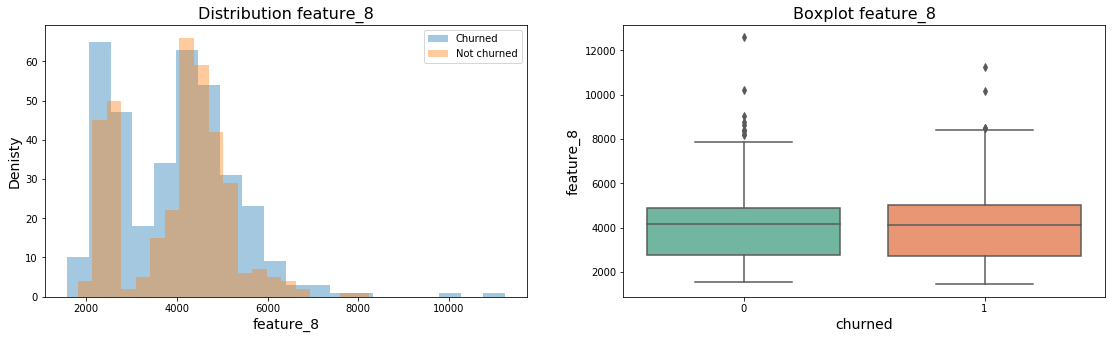

Churned
Mean: 4065.919
Median: 4119.683
Std.: 1362.607
Not churned
Mean: 4073.708
Median: 4187.763
Std.: 1262.611


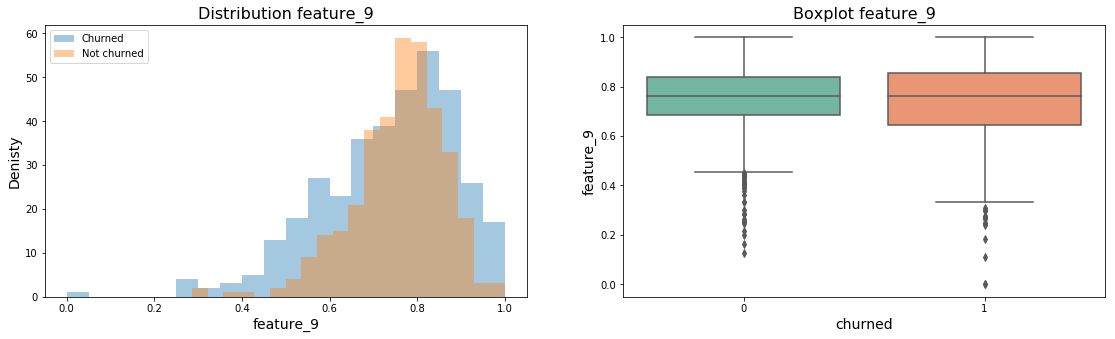

Churned
Mean: 0.739
Median: 0.764
Std.: 0.163
Not churned
Mean: 0.753
Median: 0.763
Std.: 0.123


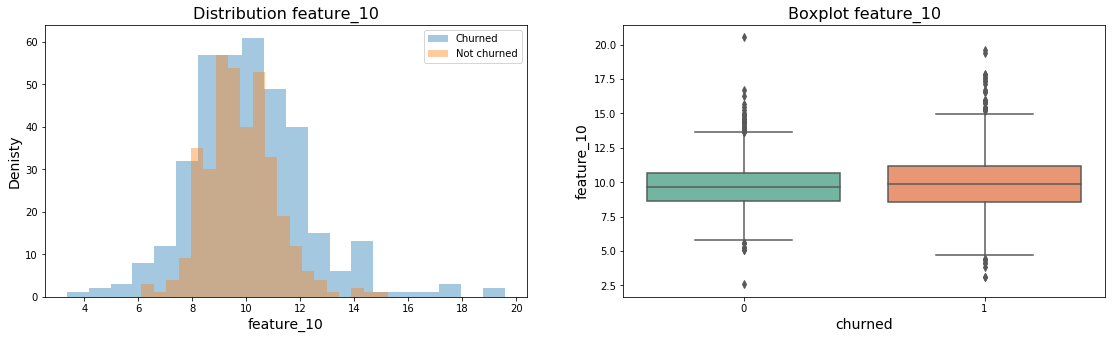

Churned
Mean: 9.942
Median: 9.873
Std.: 2.256
Not churned
Mean: 9.719
Median: 9.622
Std.: 1.587


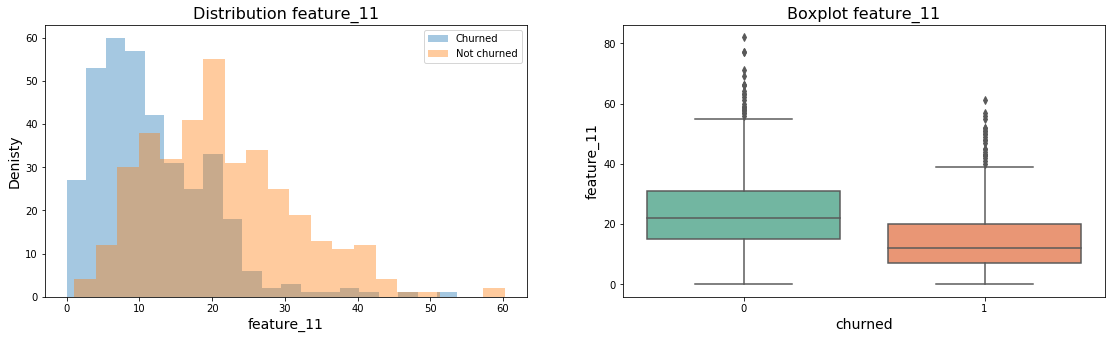

Churned
Mean: 14.443
Median: 12.0
Std.: 10.097
Not churned
Mean: 23.369
Median: 22.0
Std.: 12.13


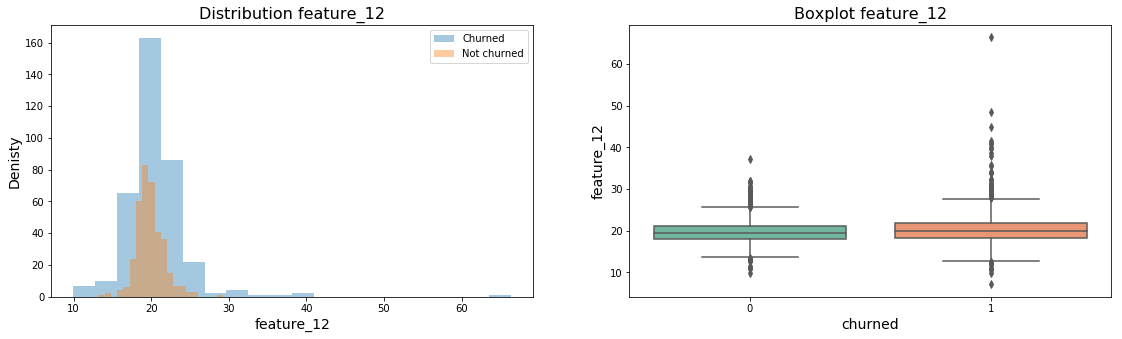

Churned
Mean: 20.436
Median: 20.005
Std.: 4.151
Not churned
Mean: 19.817
Median: 19.477
Std.: 2.669


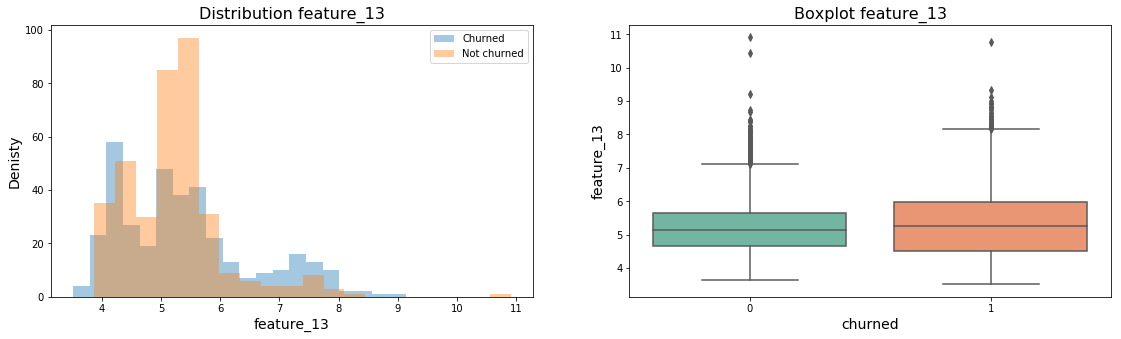

Churned
Mean: 5.436
Median: 5.248
Std.: 1.169
Not churned
Mean: 5.217
Median: 5.139
Std.: 0.856


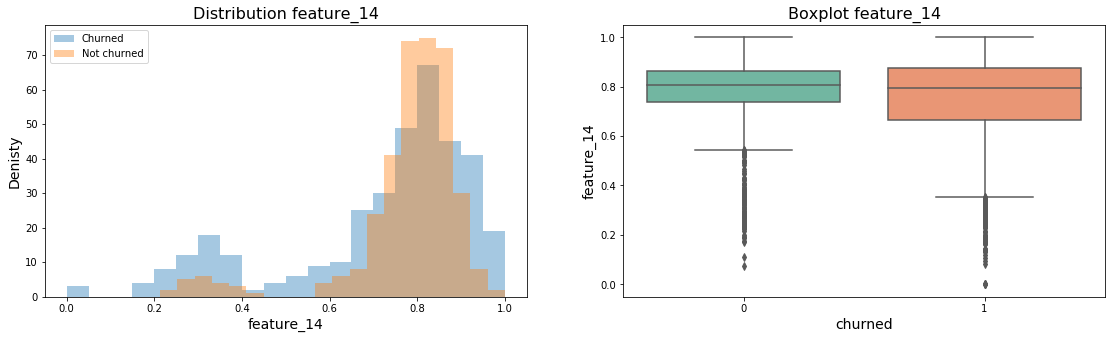

Churned
Mean: 0.733
Median: 0.795
Std.: 0.213
Not churned
Mean: 0.781
Median: 0.806
Std.: 0.135


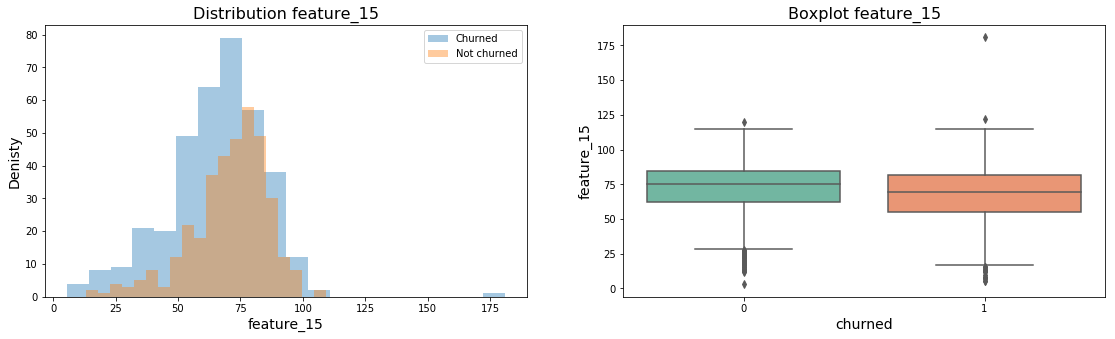

Churned
Mean: 67.249
Median: 69.304
Std.: 20.198
Not churned
Mean: 72.004
Median: 75.255
Std.: 17.563


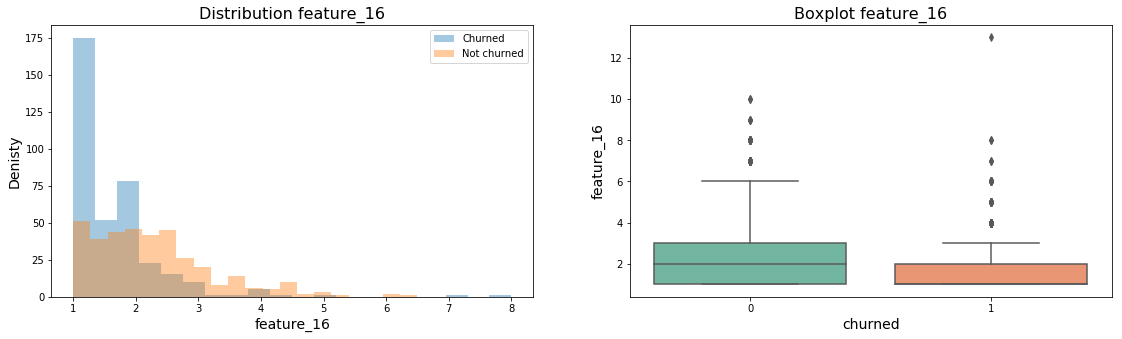

Churned
Mean: 1.765
Median: 1.0
Std.: 1.142
Not churned
Mean: 2.444
Median: 2.0
Std.: 1.594


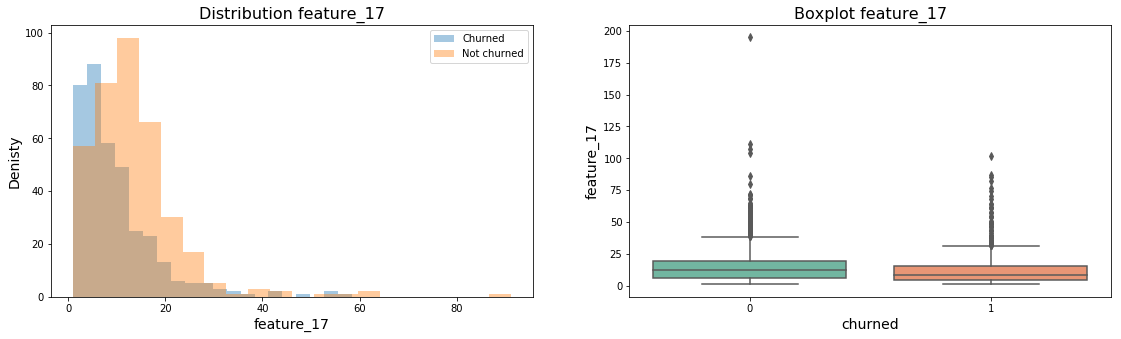

Churned
Mean: 11.396
Median: 8.0
Std.: 11.769
Not churned
Mean: 14.582
Median: 12.0
Std.: 12.624


In [23]:
for feature in plot_features:
    plot_grid(df=df_final, churn_col='churned', courier_col='courier', feature_col=feature)

#### Comments on each variable

##### Feature_1
  
  - The two distributions seem to be similar for churned and not churned couriers.

  - Visually there is a difference in the means between the two groups.
  
  - The boxplots show the presence of extreme values in this feature.
  
  - We will check in the modelling step if this variable helps to differentiate between churned and non churned couriers. 
  
  
##### Feature_2

  - The two distributions present different patterns for churned and not churned couriers.
  
  - Visually there is a difference in the means of churned and non churned couriers.
  
  - The boxplots show the presence of extreme values in this feature.
  
  - This could be an important feature to explain the differences between the two groups, which will be check in the modelling step.
  

##### Feature_3

  - Same comments as for feature 2
  
  
##### Feature_4

  - Same comments as for feature 1


##### Featuure_5

  - Same comments as for feature 1 
  
  
##### Featuure_6

  - Same comments as for feature 1 
  

##### Featuure_7

  - The distribution graph shows that for churned couriers the value is concentrated in 0.
  
  - Visually there is a difference in the means between the two groups.
  
  - The boxplots show the presence of extreme values in this feature.
  

##### Featuure_8

  - Same comments as for feature 1 


##### Featuure_9

  - Same comments as for feature 1 

##### Featuure_10

  - There seems to be some differnces on the left and right tail.


##### Featuure_11

  - Same comments as for feature 2 


##### Featuure_12

  - Same comments as for feature 1 


##### Featuure_13

  - Same comments as for feature 2
  
  - And there seems to be some differences in the right tail between churned and non churned couriers.


##### Featuure_14

  - Same comments as for feature 2


##### Featuure_15

  - Visually there is a big difference in the means values between churned and non churned couriers.


##### Featuure_16

   - Same comments as for feature 15


##### Featuure_17

  - Same comments as for feature 15
  
  
#### Some recmarks

After analysing the different visual representation of each variable we can a priori say that feature 2,3,11,13 and 14 could be consider as good feauters to explain the differences between churned and non churned couriers.

As shown in the boxplots, all features have extreme values (using the definition of the box plot outliers). However, since there is no information available on what each variable represents, it is difficult to interpret and treat these extreme values. 

For the modelling step, I will include all the features previously analyse.

### Correlation between features

Text(0.5, 1.0, 'Correlation Matrix Features 1-17')

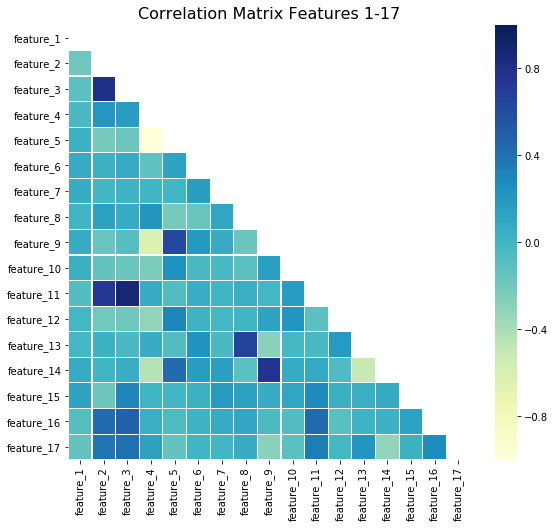

In [24]:
corrmat = df_final[plot_features].corr() 
mask = np.triu(np.ones_like(corrmat, dtype=np.bool))

f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, mask=mask, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 
ax.set_title("Correlation Matrix Features 1-17", fontsize=16)

In general, we can see that the majority of the features seem not to be highly correlated. However, feature 5 seems to be highly correlated with feature 4 and also moderate correlated with feature 9 and 14. Additionally feature 3 also seems to be highly correlated with feature 11.

Let's have a closer look to the exact correlation of these 6 features.

In [25]:
print(df_final[['feature_3','feature_4', 'feature_5', 'feature_9', 'feature_11','feature_14']].corr() ) 

            feature_3  feature_4  feature_5  feature_9  feature_11  feature_14
feature_3    1.000000   0.172822  -0.172824  -0.083210    0.877003    0.061767
feature_4    0.172822   1.000000  -1.000000  -0.630019    0.062843   -0.434895
feature_5   -0.172824  -1.000000   1.000000   0.630022   -0.062844    0.434899
feature_9   -0.083210  -0.630019   0.630022   1.000000   -0.010982    0.765442
feature_11   0.877003   0.062843  -0.062844  -0.010982    1.000000    0.093100
feature_14   0.061767  -0.434895   0.434899   0.765442    0.093100    1.000000


The correlation matrix confirms that feature 4 and 5 are highly correlated and also feature 3 and 11 are highly correlated.

Since the exact coorrelation coefficente between fetaure 4 and 5 is 1, I will drop feature_4 for the following analysis. 


In [26]:
df_final.drop('feature_4', axis=1, inplace=True) 

## 3. Create predictive algorithm

### Prepare data for modelling

In this step I preprocess the raw features for the next predictive modelling step. I follow the next steps:

   - Aggregate the data into a courier level (at the moment we have the data on a weekly level)
   
   - Enconde categorical features 
   
  

In [27]:
df_aggregation = df_final.groupby('courier').agg({'churned':'mean'
                                                  , 'category_one':'unique'
                                                  , 'category_two':'mean'
                                                  , 'work_ratio':'mean'
                                                  , 'worked_three_weeks_in_row':'mean'
                                                  , 'feature_1': ['mean', 'sum']
                                                  , 'feature_2': ['mean', 'sum']
                                                  , 'feature_3': ['mean', 'sum']
                                                  , 'feature_5': 'mean' 
                                                  , 'feature_6': ['mean', 'sum']
                                                  , 'feature_7': 'mean' 
                                                  , 'feature_8': ['mean', 'sum']
                                                  , 'feature_9': 'mean' 
                                                  , 'feature_10': ['mean','sum'] 
                                                  , 'feature_11': ['mean','sum']
                                                  , 'feature_12': ['mean','sum'] 
                                                  , 'feature_13': ['mean','sum']
                                                  , 'feature_14':'mean' 
                                                  , 'feature_15': ['mean', 'sum']
                                                  , 'feature_16': ['mean', 'sum']
                                                  , 'feature_17': ['mean', 'sum']
                                                 })

For the aggregation of feature 1 to 17, I consider just the mean value when the values of the variable are between 0 and 1. For the rest of the cases I group using the mean and sum of each variable.

In [28]:
def get_unique_element(col_list):
    return col_list[0]

In [29]:
df_aggregation.columns = ["_".join(x) for x in df_aggregation.columns.ravel()]

In [30]:
df_aggregation['category_one_unique'] = df_aggregation.category_one_unique.apply(get_unique_element)

The next step is to encode the categorical features

In [31]:
df_model=pd.get_dummies(df_aggregation, prefix=['category_one_unique'], drop_first=True )

### Predictive modeling

Let’s sort out the steps to follow for building the predictive model:

   - Split data into target and features
   
   - Split data into training and test set
   
   - Select the classification algorithms that we want to fit
   
   - Grid search with cross validation to select the best performing model

#### Split data into target and features

In [32]:
X = df_model.drop(['churned_mean'], axis=1)
y = df_model['churned_mean']  

#### Split data into training and test set

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

#### Select clasification algorithms 

I will train three different algorithm classifiers: 

   - Logistic Regression 
   
   - Gradient Boosting Machine (GBM) 
   
   - Random Forest
   

These three models predict in different ways. First, the logistic regression models the probability of a certain class using a lineal regression approach. Gradient Boosting is a tree model and a non parametric approach were it first fits simple models several times, each time focusing on those data points hard to fit to get them right. Random Forest is also a non parametric approach but it grows multiple independent decisions trees and it choses as output the class having the most votes over all the trees. 

#### Set grid search parameters

Since the idea is to test more than one algorithm with more than one hyper-parameter in order to find the best possible model, I use a pipeline which allows to do this in a code-efficient manner. 

For this step, I create a dictionary with the different algorithms and the hyperparameters for tuning.

- Logistic regression: C is the regularization strength (For big values of C, we low the power of regularization which imples the model is allowed to increase it's complexity)

- GBM: number of trees, maximum depth of a tree, and learning rate.

- Random Forest: number of trees, maximum deph in each decision tree and maximum number of features considered for splitting a node



In [34]:
# Create a pipeline
pipe = Pipeline([("classifier", RandomForestClassifier())])
# Create dictionary with candidate learning algorithms and their hyperparameters
param_grid = [
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2','l1'],
                 "classifier__C": np.logspace(0, 4, 10)
                 },
                {"classifier": [GradientBoostingClassifier()],
                 "classifier__n_estimators": [10, 100, 200],
                 "classifier__max_depth":[5,6,7,10,12],
                 "classifier__learning_rate" : np.arange(0.01, 0.1, 0.05)
                },
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 200],
                 "classifier__max_depth":[5,10,15,25],
                 "classifier__max_features": ['auto', 'sqrt']}]



#### Grid search with cross validation

In this step I perform a grid search in order to find the best performing model based on the f1 score. In this grid search I find the best hyperparameters for each algorithm combined with a cross validation with 5 folds. 

In [35]:
# Create a gridsearch of the pipeline, to fit the best model
gridsearch_clas_f1 = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='f1', cv=5, verbose=0,n_jobs=-1) 
gridsearch_results = gridsearch_clas_f1.fit(X_train, y_train)

best_score = gridsearch_results.best_score_
best_paramters = gridsearch_results.best_params_


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Best performing model

In [36]:
best_paramters['classifier']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
best_params =  [keys for keys in best_paramters.keys() if keys.startswith('classifier__') ]

In [38]:
for param in best_params:
    print(param, best_paramters[param])

classifier__max_depth 5
classifier__max_features auto
classifier__n_estimators 100


According to the pipeline search the Random Forest classifier performs better than the other classifiers using the f1 score as metric of comparison.

I will use this model with its associated parameters to predict the churn couriers. 

## 4. Evaluating the best performing model 

In [39]:
params = {key.split('__')[1]:best_paramters[key] for key in best_paramters if key.startswith('classifier__')}

In [40]:
rf_model = RandomForestClassifier(**params).fit(X_train, y_train)

In [41]:
#Predict values based on new parameters
y_pred = rf_model.predict(X_test)


In [42]:
rf_confusion_matrix = confusion_matrix(y_test, y_pred)
rf_classification_report = classification_report(y_test, y_pred)

print(rf_classification_report)

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       119
           1       0.68      0.75      0.71       100

   micro avg       0.73      0.73      0.73       219
   macro avg       0.73      0.73      0.73       219
weighted avg       0.73      0.73      0.73       219



In [43]:
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred),2))

Accuracy: 0.73


Analysing the classification report, we observe that the model has an accuracy of 73%, which indicates that 73 couriers out of 100 are correctly classified between churned and non churned. Considering the precision, 68% of the couriers that were classified as churned were actually churned couriers. The model shows a recall of 75%, which tells us that the model classifies 75% as churned couriers from all churned couriers.


#### ROC curve

In [44]:
y_proba = rf_model.predict_proba(X_test)[:, 1]

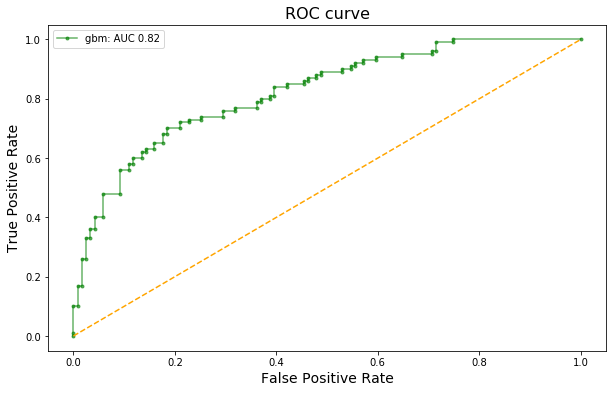

In [45]:
fp, tp, thresholds = roc_curve(y_test, y_proba)
auc = np.round(roc_auc_score(y_test, y_proba),2)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(fp, tp, marker='.', color='green', alpha=0.6, label='gbm: AUC '+str(auc))
ax.plot(fp, fp, linestyle='--', color='orange')

plt.title("ROC curve", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=14)
plt.legend()

### Feature importance

In this last step I want to figure out what predictor variables the GBM model considers most important.

The features that show the highest realtive importance score is feature 3.

In order to scale up the predictions, we could potencially use the feature importance to remove the features with the lowest imprtance scores. This would make sense, for example if we have to make predictions on a weekly basics for all cities. 

In [46]:
feature_imp = pd.Series(rf_model.feature_importances_,index=X_train.columns).sort_values(ascending=False)

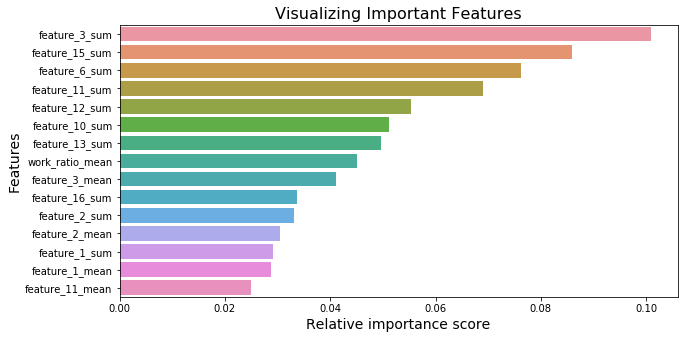

In [47]:
f, ax = plt.subplots(figsize =(10, 5)) 
sns.barplot(x=feature_imp[:15], y=feature_imp.index[:15])
plt.xlabel('Relative importance score',  fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title("Visualizing Important Features",  fontsize=16)
plt.show()

## Final results and comments

The main goal of this excersise was to give the prediction of the churned and not chuned couriers to the city manager, so he/she can size the fleet of couriers in order to properly serve the expected orders in the next weeks.

By using the churn prediction model the city manager is in a better position than if he/she were to determine the churned couriers by chance (where the probability of the courier working or not in the next weeks is 50/50). Then, without the model, in order to size the fleets it would be needed to take into account this 50% of error by chance and have the double amount of couriers to cover all the expected orders. However, with the model and considering the level of accuracy, this error reduces to 27%. Therefore, the number of extra couriers (due to the error) needed would be lower. 